# Imports

In [57]:
import os

import numpy as np
from matplotlib import pyplot as plt

In [58]:
from IPython.display import clear_output

from djimaging.user.alpha.utils import database

indicator = 'calcium'
database.connect_dj(indicator=indicator)
clear_output()

In [59]:
exp_tab = database.get_experiment_tab()
field_tab = database.get_field_tab()

# Load data

In [60]:
from djimaging.user.alpha.utils.populate_alpha import PROJECT_ROOT
cell_id = 1

if cell_id == 1:
    expdate = "20200708"
    expnum = 1
elif cell_id == 2:
    expdate = "20200713"
    expnum = 1

smi_data_path = os.path.join(PROJECT_ROOT, "data/Ran/SMI32")
os.listdir(smi_data_path)

['F20200708C1_z0_ch01.tif',
 'F20200708C1_z0_ch00.tif',
 'F20200713C1_z0_ch00.tif',
 'F20200713C1_z0_ch01.tif']

## Normalize SMI data

In [61]:
from djimaging.utils import math_utils
import tifffile

In [62]:
smi_data_ch0 = math_utils.normalize_zero_one(
    tifffile.imread(os.path.join(smi_data_path, f'F{expdate}C{expnum}_z0_ch00.tif')))
smi_data_ch1 = math_utils.normalize_zero_one(
    tifffile.imread(os.path.join(smi_data_path, f'F{expdate}C{expnum}_z0_ch01.tif')))

In [63]:
smi_data_ch1.shape

(8, 1024, 1024)

In [64]:
smi_avg_ch0 = math_utils.normalize_zero_one(np.mean(smi_data_ch0, axis=0))
smi_avg_ch1 = math_utils.normalize_zero_one(np.percentile(smi_data_ch1, axis=0, q=20))

In [65]:
smi_avg_ch0.shape

(1024, 1024)

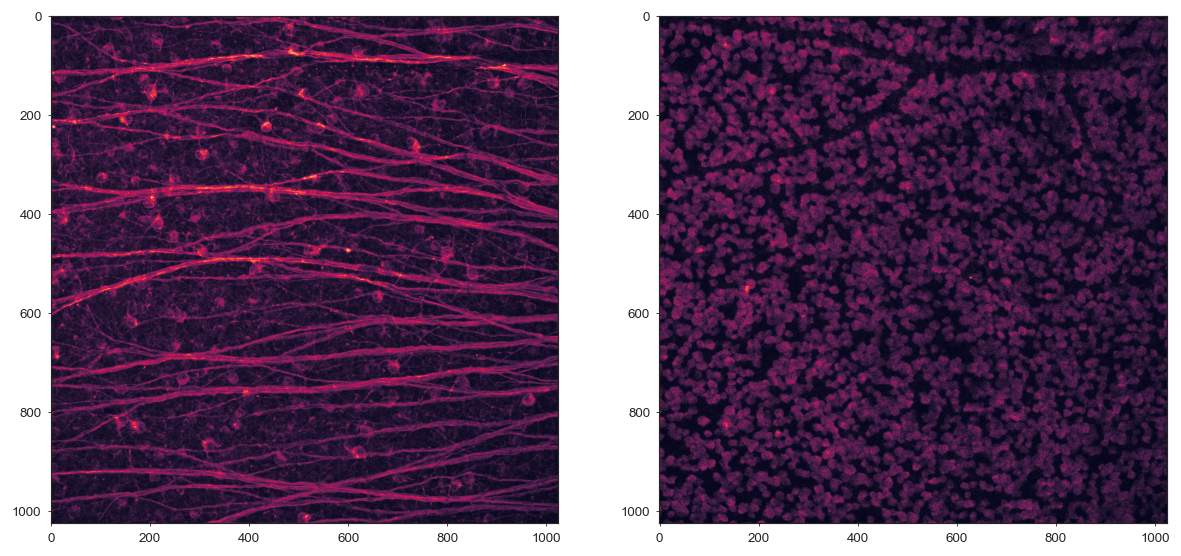

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
ax = axs[0]
ax.imshow(smi_avg_ch0)
ax = axs[1]
ax.imshow(smi_avg_ch1)
plt.show()

## Normalize zStack of cell

In [67]:
from djimaging.utils import data_utils

stack_pixel_size_um = (field_tab & dict(date=expdate, field='stack')).fetch1('pixel_size_um')
stack_path = (field_tab & dict(date=expdate, field='stack')).fetch1('fromfile')
stack_data = data_utils.load_h5_data(stack_path)

In [68]:
from skimage.transform import rotate

44

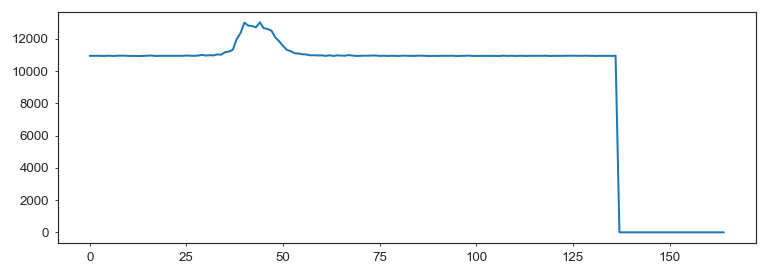

In [69]:
plt.plot(stack_data["wDataCh0"][272, 262])
np.argmax(stack_data["wDataCh0"][272, 262])

In [70]:
stack_avg_ch0 = math_utils.normalize_zero_one(np.mean(stack_data["wDataCh0"][:, :, 20:100], axis=2))
stack_avg_ch1 = math_utils.normalize_zero_one(np.mean(stack_data["wDataCh1"][:, :, 20:100], axis=2))

In [71]:
stack_avg_ch1.shape

(512, 512)

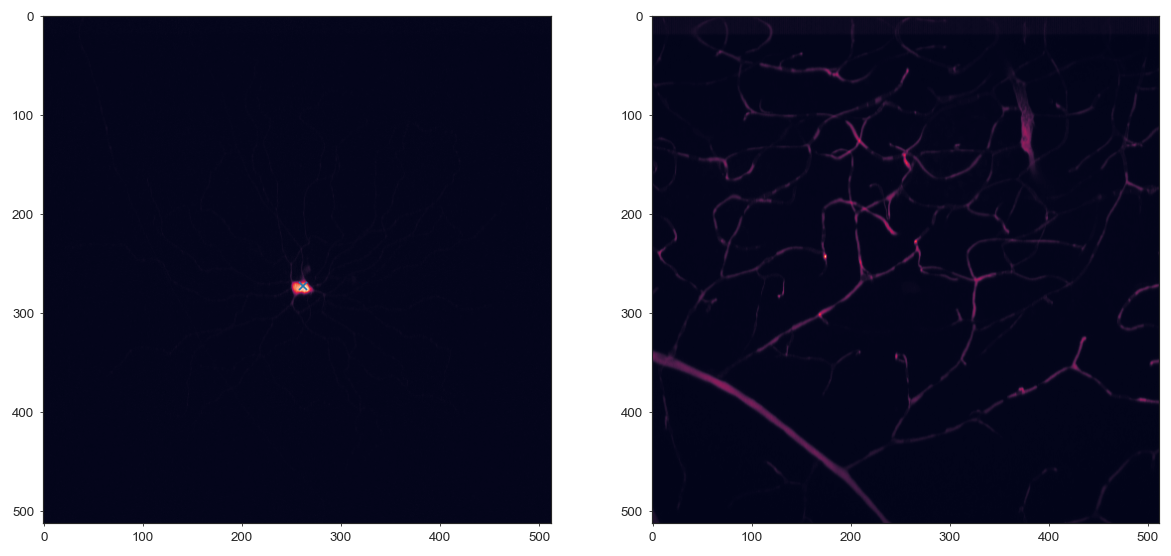

In [72]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
ax = axs[0]
ax.imshow(rotate(stack_avg_ch0, angle=0))
ax.plot([262], [272], 'x')
ax = axs[1]
ax.imshow(rotate(stack_avg_ch1, angle=0))
plt.show()

## Get size of data

In [73]:
smi_size_um = (721.41, 721.41, -17.99)  # From image see above, same for all
smi_pixel_size_um = (0.705, 0.705, -1.999)  # From image see above, same for all

smi_extent = np.array([0, smi_size_um[0], 0, smi_size_um[1]])
smi_extent

array([  0.  , 721.41,   0.  , 721.41])

In [74]:
stack_extent = np.array(
    [0, stack_avg_ch0.shape[0] * stack_pixel_size_um, 0, stack_avg_ch0.shape[1] * stack_pixel_size_um])
stack_extent

array([  0.     , 476.66688,   0.     , 476.66688])

## Align data

In [75]:
if cell_id == 1:
    angle = -121
    depth_idx = 3
    scale = 0.921
    rot_stack_offset_um = (-50, -3)
elif cell_id == 2:
    angle = 56.9
    rot_stack_offset_um = (27.2, 13)
    scale = 0.912
    depth_idx = 3

rot_stack = rotate(stack_avg_ch1, angle=angle, cval=np.nan, resize=True)
rot_stack_mask = rot_stack.copy()
rot_stack_mask[rot_stack < 0.05] = np.nan

rot_cell_mask = rotate(stack_avg_ch0, angle=angle, cval=np.nan, resize=True)
rot_cell_mask[rot_cell_mask < 0.03] = np.nan

rot_stack_extent = np.array([
    rot_stack_offset_um[0], rot_stack_offset_um[0] + rot_stack_mask.shape[0] * stack_pixel_size_um,
    rot_stack_offset_um[1], rot_stack_offset_um[1] + rot_stack_mask.shape[1] * stack_pixel_size_um]
)

smi_extent_shrink = smi_extent * scale

In [76]:
cmap1 = 'viridis'
cmap2 = 'plasma'

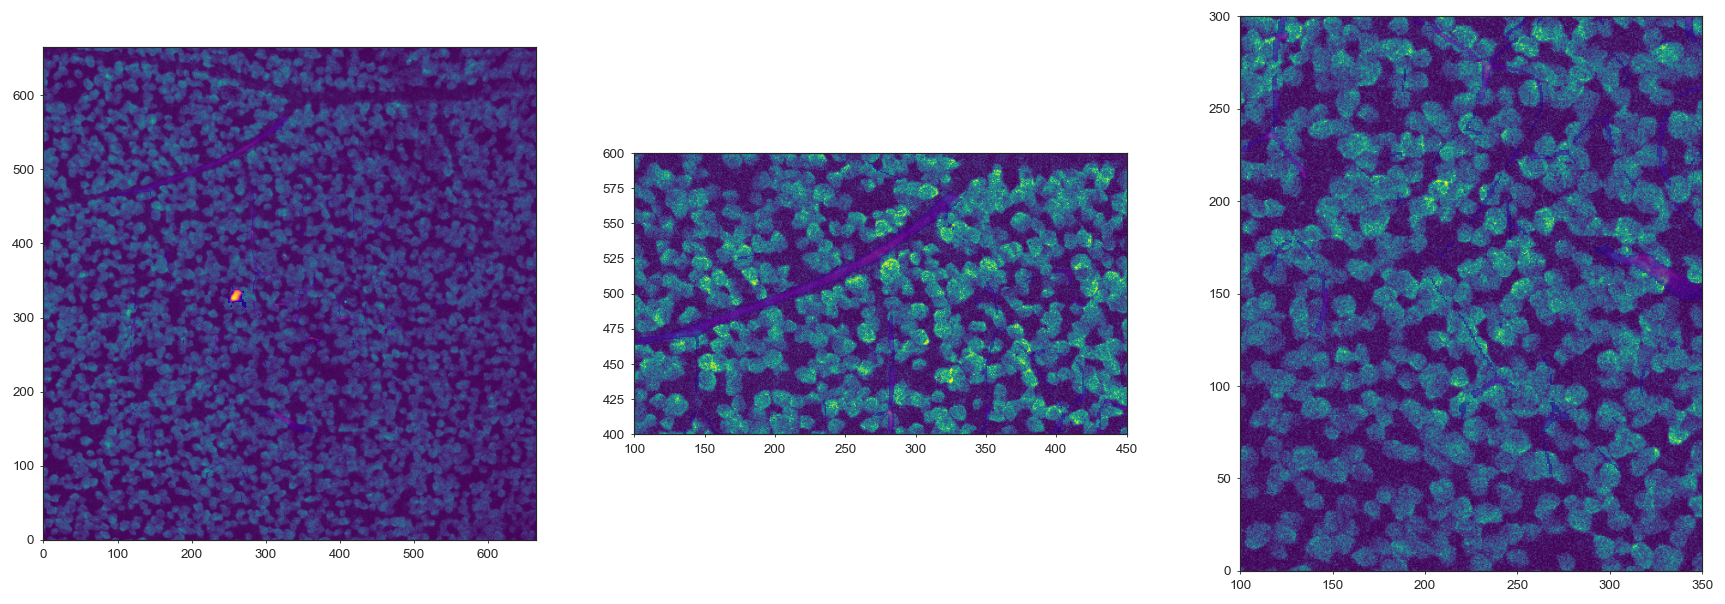

In [77]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

ax = axs[0]
ax.imshow(rot_stack_mask, extent=rot_stack_extent, alpha=0.5, cmap=cmap2)
ax.imshow(rot_cell_mask, extent=rot_stack_extent, cmap=cmap2)
ax.imshow(smi_avg_ch1, extent=smi_extent_shrink, cmap=cmap1, zorder=-10)

ax = axs[1]
ax.imshow(smi_data_ch1[depth_idx], extent=smi_extent_shrink, cmap=cmap1, zorder=-10)
ax.imshow(rot_stack_mask, extent=rot_stack_extent, alpha=0.5, cmap=cmap2)
ax.set(xlim=(100, 450), ylim=(400, 600))

ax = axs[2]
ax.imshow(smi_data_ch1[depth_idx], extent=smi_extent_shrink, cmap=cmap1, zorder=-10)
ax.imshow(rot_stack_mask, extent=rot_stack_extent, alpha=0.5, cmap=cmap2)
ax.set(xlim=(100, 350), ylim=(0, 300))

plt.show()

## Select region of cell for zoom in

In [78]:
if cell_id == 1:
    rot_cell_extent = rot_stack_extent + np.array([9, 9, 2, 2])
    zoom_xpos = 410
    zoom_ypos = 510
elif cell_id == 2:
    rot_cell_extent = rot_stack_extent + np.array([0, 0, -4.8, -4.8])
    zoom_xpos = 275
    zoom_ypos = 250

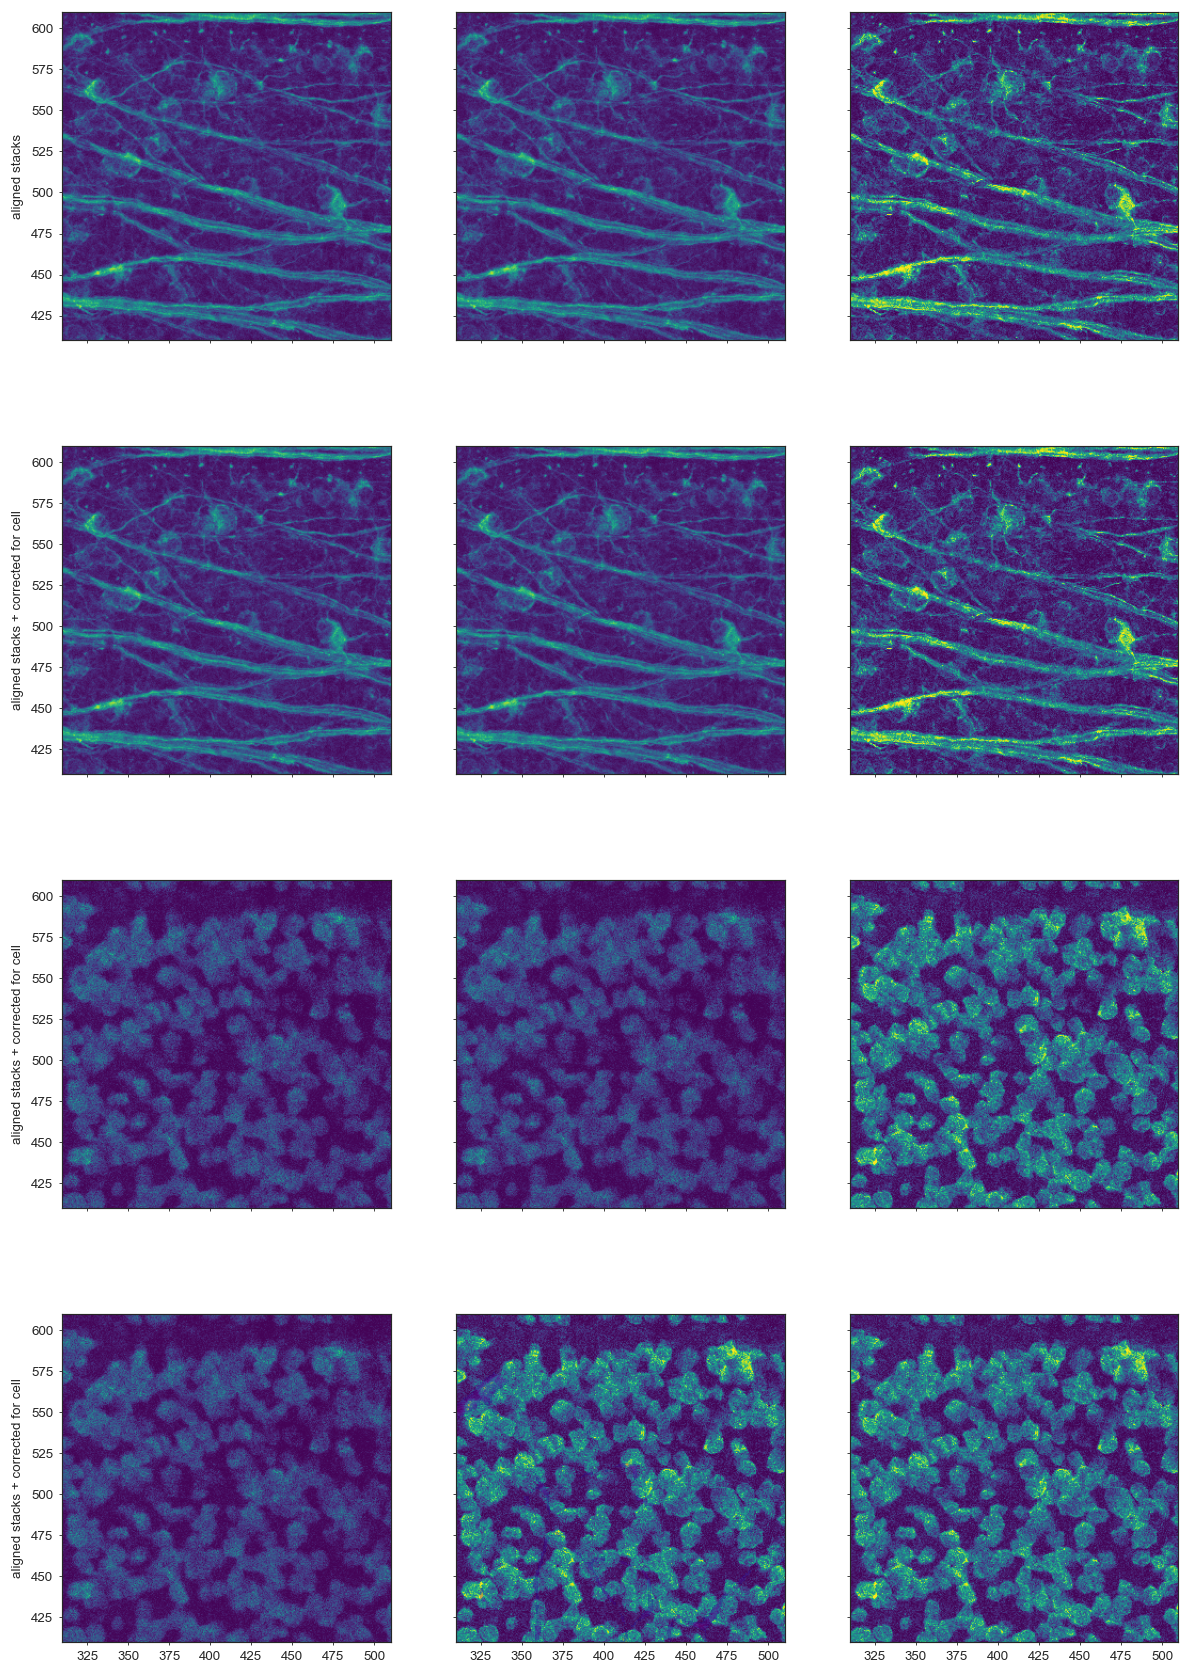

In [79]:
fig, axs = plt.subplots(4, 3, figsize=(12, 18), sharey='all', sharex='all')

ax = axs[0, 0]
ax.imshow(smi_avg_ch0, extent=smi_extent_shrink, cmap=cmap1, zorder=-10)
ax.set(ylabel='aligned stacks')

ax = axs[0, 1]
ax.imshow(smi_avg_ch0, extent=smi_extent_shrink, cmap=cmap1, zorder=-10)
ax.imshow(rot_cell_mask, extent=rot_stack_extent, alpha=0.3, cmap=cmap2)

ax = axs[0, 2]
ax.imshow(smi_data_ch0[depth_idx], extent=smi_extent_shrink, cmap=cmap1, zorder=-10)

ax = axs[1, 0]
ax.imshow(smi_avg_ch0, extent=smi_extent_shrink, cmap=cmap1, zorder=-10)
ax.set(ylabel='aligned stacks + corrected for cell')

ax = axs[1, 1]
ax.imshow(smi_avg_ch0, extent=smi_extent_shrink, cmap=cmap1, zorder=-10)
ax.imshow(rot_cell_mask, extent=rot_cell_extent, alpha=0.3, cmap=cmap2)

ax = axs[1, 2]
ax.imshow(smi_data_ch0[depth_idx], extent=smi_extent_shrink, cmap=cmap1, zorder=-10)

ax = axs[2, 0]
ax.set(ylabel='aligned stacks + corrected for cell')
ax.imshow(smi_avg_ch1, extent=smi_extent_shrink, cmap=cmap1, zorder=-10)

ax = axs[2, 1]
ax.imshow(smi_avg_ch1, extent=smi_extent_shrink, cmap=cmap1, zorder=-10)
ax.imshow(rot_cell_mask, extent=rot_cell_extent, alpha=0.3, cmap=cmap2)

ax = axs[2, 2]
ax.imshow(smi_data_ch1[depth_idx], extent=smi_extent_shrink, cmap=cmap1, zorder=-10)

ax = axs[3, 0]
ax.set(ylabel='aligned stacks + corrected for cell')
ax.imshow(smi_avg_ch1, extent=smi_extent_shrink, cmap=cmap1, zorder=-10)

ax = axs[3, 1]
ax.imshow(smi_data_ch1[depth_idx], extent=smi_extent_shrink, cmap=cmap1, zorder=-10)
ax.imshow(rot_stack_mask, extent=rot_cell_extent, alpha=0.3, cmap=cmap2)

ax = axs[3, 2]
ax.imshow(smi_data_ch1[depth_idx], extent=smi_extent_shrink, cmap=cmap1, zorder=-10)

ax.set(xlim=(zoom_xpos - 100, zoom_xpos + 100), ylim=(zoom_ypos - 100, zoom_ypos + 100))

plt.show()

In [80]:
fig, axs = plt.subplots(3, 2, figsize=(12, 18))
ax = axs[0, 0]
ax.imshow(rot_stack, extent=rot_stack_extent, cmap=cmap2)

ax = axs[1, 0]
ax.imshow(smi_avg_ch1, extent=smi_extent_shrink, cmap=cmap2)

ax = axs[0, 1]
ax.imshow(rot_stack_mask, extent=rot_stack_extent, cmap=cmap2)

ax = axs[1, 1]
ax.imshow(rot_stack_mask, extent=rot_stack_extent, cmap=cmap2)
ax.imshow(rot_cell_mask, extent=rot_stack_extent, cmap=cmap2)
ax.imshow(smi_avg_ch1, extent=smi_extent_shrink, cmap=cmap1, zorder=-10)

ax = axs[2, 0]
ax.imshow(rot_stack_mask, extent=rot_stack_extent, cmap=cmap2)
ax.imshow(rot_cell_mask, extent=rot_stack_extent, cmap=cmap2)
ax.imshow(smi_avg_ch0, extent=smi_extent_shrink, cmap=cmap1, zorder=-10)

ax = axs[2, 1]
ax.axis('off')
plt.show()

# Figure

In [81]:
from alphaanalysis import plot as plota

In [82]:
plota.set_default_params()

In [83]:
norm_smi_avg_ch0 = plota.normalize_stack(np.flipud(np.rot90((smi_data_ch0.T))), q_low=0.5, q_high=0.0001)
norm_smi_avg_ch1 = plota.normalize_stack(np.flipud(np.rot90((smi_data_ch1.T))), q_low=0.5, q_high=0.0001)
norm_smi_avg_ch0.shape

(1024, 1024, 8)

## Rotate image

In [84]:
from skimage.transform import rotate

In [85]:
ca_data_ch0 = rotate(stack_data["wDataCh0"][:, :, 20:100], angle=angle, cval=np.nan, resize=True)
ca_data_ch1 = rotate(stack_data["wDataCh1"][:, :, 20:100], angle=angle, cval=np.nan, resize=True)

ca_data_ch0.shape

(702, 702, 80)

In [86]:
plt.imshow(ca_data_ch1.mean(axis=2));

In [87]:
norm_ca_data_ch0 = plota.normalize_stack(ca_data_ch0, q_low=60, q_high=0.025)
norm_ca_data_ch1 = plota.normalize_stack(ca_data_ch1, q_low=0.01, q_high=0.01)  #0.0001)

norm_ca_data_ch0 = np.nan_to_num(norm_ca_data_ch0, 0)
norm_ca_data_ch1 = np.nan_to_num(norm_ca_data_ch1, 0)

## Rescale image

In [88]:
from skimage.transform import rescale

In [89]:
f_rescale = (
stack_pixel_size_um / (smi_pixel_size_um[0] * scale), stack_pixel_size_um / (smi_pixel_size_um[1] * scale), 1)
print(f_rescale)
norm_scaled_ca_data_ch0 = rescale(norm_ca_data_ch0, scale=f_rescale)
norm_scaled_ca_data_ch1 = rescale(norm_ca_data_ch1, scale=f_rescale)

(1.433825397925474, 1.433825397925474, 1)


In [90]:
norm_ca_data_ch0.shape

(702, 702, 80)

In [91]:
norm_smi_avg_ch1.shape

(1024, 1024, 8)

In [92]:
norm_scaled_ca_data_ch1.shape

(1007, 1007, 80)

## Shift image

In [93]:
from skimage.transform import warp

In [94]:
cell_id

1

In [95]:
if cell_id == 1:
    shift_x = -61  # > shift SMI32 to left
    shift_y = 16  # > shift SMI32 to top
elif cell_id == 2:
    shift_x = 41  # > shift SMI32 to left
    shift_y = 279  # > shift SMI32 to top

shift_x, shift_y

(-61, 16)

In [96]:
translation_matrix = np.array([[1, 0, shift_x],
                               [0, 1, shift_y],
                               [0, 0, 1]])

norm_shifted_smi_avg_ch0 = warp(norm_smi_avg_ch0, translation_matrix)
norm_shifted_smi_avg_ch1 = warp(norm_smi_avg_ch1, translation_matrix)

In [97]:
norm_shifted_smi_avg_ch0.shape

(1024, 1024, 8)

In [98]:
norm_scaled_ca_data_ch1.shape

(1007, 1007, 80)

## Crop image

In [99]:
final_shape = np.min([norm_shifted_smi_avg_ch0.shape[:2], norm_scaled_ca_data_ch1.shape[:2]], axis=0)
final_shape

array([1007, 1007])

In [100]:
crop_norm_shifted_smi_avg_ch0 = norm_shifted_smi_avg_ch0[:final_shape[0], :final_shape[1]]
crop_norm_shifted_smi_avg_ch1 = norm_shifted_smi_avg_ch1[:final_shape[0], :final_shape[1]]

In [101]:
crop_norm_scaled_ca_data_ch0 = norm_scaled_ca_data_ch0[:final_shape[0], :final_shape[1]]
crop_norm_scaled_ca_data_ch1 = norm_scaled_ca_data_ch1[:final_shape[0], :final_shape[1]]

## Resize z

In [102]:
z_crop_norm_scaled_ca_data_ch0 = crop_norm_scaled_ca_data_ch0.reshape(
    tuple(final_shape) + (crop_norm_shifted_smi_avg_ch0.shape[2], -1)).max(axis=-1)
z_crop_norm_scaled_ca_data_ch1 = crop_norm_scaled_ca_data_ch1.reshape(
    tuple(final_shape) + (crop_norm_shifted_smi_avg_ch0.shape[2], -1)).max(axis=-1)

## Z projection

In [103]:
col_stack_z_proj, col_stacks = plota.get_col_stack_merged_z(
    norm_stacks=[
        z_crop_norm_scaled_ca_data_ch0,
        z_crop_norm_scaled_ca_data_ch1,
        crop_norm_shifted_smi_avg_ch1,
        crop_norm_shifted_smi_avg_ch0,
    ],
    colors=['lime', 'yellow', 'royalblue', 'magenta'],
    gammas=[1., 1., 1., 1.],
    gammaz=2., offz=1., plot=False)
col_stack_z_proj.shape

(1007, 1007, 3)

In [104]:
col_stack_z_proj_zoom, col_stacks_zoom = plota.get_col_stack_merged_z(
    norm_stacks=[z_crop_norm_scaled_ca_data_ch0, crop_norm_shifted_smi_avg_ch0],
    colors=['lime', 'magenta'],
    gammas=[1., 1.],
    gammaz=2., offz=1., plot=False)

col_stack_z_proj_zoom.shape

(1007, 1007, 3)

## Plot

In [105]:
import matplotlib.patheffects as pe
from matplotlib import patches

In [106]:
if cell_id == 1:
    cell_x_pos = 476
    cell_y_pos = 496
elif cell_id == 2:
    cell_x_pos = 387
    cell_y_pos = 356

zoom_extra = 100  # Extra space around zoom center

In [107]:
def highlight_cell(ax, zoom=False, arrow=False):
    if arrow:
        patch = patches.Arrow(cell_x_pos - 100, cell_y_pos - 100, 100, 100, width=50,
                              edgecolor='k', facecolor='w', lw=0.3)
    else:
        patch = patches.Circle((cell_x_pos, cell_y_pos), radius=30, edgecolor='w', facecolor='none', lw=1.5,
                               linestyle=(0, (1, 0.97)) if zoom else (0, (1, 0.5)))

    ax.add_patch(patch)

In [108]:
def plot_scale_bar(ax, text=False, zoom=False, size=100):
    if zoom:
        borderpad = 0.03 * (zoom_extra * 2)

        plota.plot_scale_bar(
            ax=ax, x0=(cell_x_pos + zoom_extra) - size - borderpad, y0=(cell_y_pos + zoom_extra) - borderpad, size=size,
            pad=-(cell_y_pos + zoom_extra) * 0.015,
            text=f"{size} µm" if text else None,
            color='w', text_va='bottom', text_x_pad=size / 2, text_ha='right')
    else:
        borderpad = 0.03 * col_stack.shape[0]

        xlim = ax.get_xlim()
        ylim = ax.get_ylim()

        plota.plot_scale_bar(
            ax=ax, x0=xlim[1] - size - borderpad, y0=ylim[0] - borderpad, size=size,
            pad=-np.abs(xlim[1] - xlim[0]) * 0.03,
            text=f"{size} µm" if text else None,
            color='w', text_va='bottom', text_x_pad=size / 2, text_ha='right')

In [109]:
fig, axs = plt.subplots(1, len(col_stacks) + 1, figsize=(7, 1.7), sharex='all', sharey='all')

for ax, col_stack in zip(axs[:-1], col_stacks):
    ax.imshow(np.max(col_stack, axis=2))
axs[-1].imshow(col_stack_z_proj)

for i, ax in enumerate(axs):
    highlight_cell(ax)

plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=0.5)

for i, ax in enumerate(axs):
    plot_scale_bar(ax=ax, text=i == 0)

plt.show()

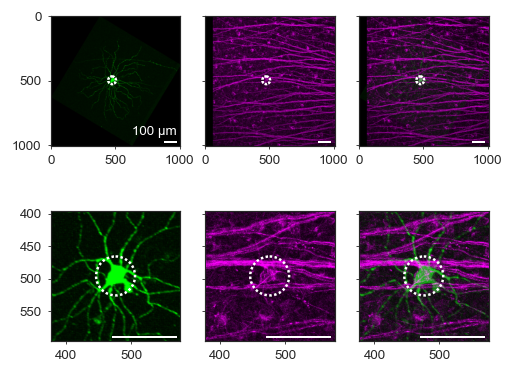

In [110]:
fig, axs = plt.subplots(2, len(col_stacks_zoom) + 1, figsize=(7 * 3 / 5, 1.7 * 2), sharex='row', sharey='row')

for ax_row in axs:
    for ax, col_stack in zip(ax_row[:-1], col_stacks_zoom):
        ax.imshow(np.max(col_stack, axis=2))
    ax_row[-1].imshow(col_stack_z_proj_zoom)

axs[1, 0].set(xlim=(cell_x_pos - zoom_extra, cell_x_pos + zoom_extra),
              ylim=(cell_y_pos + zoom_extra, cell_y_pos - zoom_extra))

for i, ax in enumerate(axs.flat):
    highlight_cell(ax, zoom=i >= 3)

plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=0.5)

for i, ax in enumerate(axs[0, :]):
    plot_scale_bar(ax=ax, text=i == 0)

for i, ax in enumerate(axs[1, :]):
    plot_scale_bar(ax=ax, text=False, zoom=True)

plt.show()

In [111]:
def annotate_z_proj(ax, text):
    ax.text(0.03, 1 - 0.03, text, transform=ax.transAxes, va='top', ha='left', c='w',
            path_effects=[pe.withStroke(linewidth=1, foreground="k")])

In [112]:
fig, axs = plt.subplots(2, len(col_stacks), figsize=(7, 3.5))

for ax in axs.flat:
    ax.axis('off')

for ax, col_stack in zip(axs[0, :], col_stacks):
    ax.imshow(np.max(col_stack, axis=2))

annotate_z_proj(axs[0, 0], 'OGB-1')
annotate_z_proj(axs[0, 1], 'SR-101')
annotate_z_proj(axs[0, 2], 'RBPMS')
annotate_z_proj(axs[0, 3], 'SMI-32')

for ax in np.append(axs[0, :], axs[1, 0]):
    highlight_cell(ax)

annotate_z_proj(axs[1, 0], 'OGB-1\nSR-101\nRBPMS\nSMI-32')
axs[1, 0].imshow(col_stack_z_proj)
axs[1, 0].add_patch(patches.Rectangle(xy=(cell_x_pos - zoom_extra, cell_y_pos - zoom_extra), width=zoom_extra * 2,
                                      height=zoom_extra * 2,
                                      ec='w', fc='none', ls=':', lw=1))

for ax, col_stack in zip(axs[1, 1:-1], col_stacks_zoom):
    ax.imshow(np.max(col_stack, axis=2))
axs[1, -1].imshow(col_stack_z_proj_zoom)

annotate_z_proj(axs[1, 1], 'OGB-1')
annotate_z_proj(axs[1, 2], 'SMI-32')
annotate_z_proj(axs[1, 3], 'OGB-1\nSMI-32')

for ax in (axs[1, 1:]):
    highlight_cell(ax, zoom=True)

if shift_x < 0 or shift_y < 0:
    for ax in np.append(axs[0, :], axs[1, 0]):
        vmin = np.maximum(-shift_x, -shift_y)
        vmax = np.min(col_stack.shape[:2]) - vmin
        ax.set(xlim=(vmin, vmax), ylim=(vmax, vmin))
else:
    vmin = 50
    vmax = np.min(col_stack.shape[:2]) - 50

for ax in axs[1, 1:]:
    ax.set(xlim=(cell_x_pos - zoom_extra, cell_x_pos + zoom_extra),
           ylim=(cell_y_pos + zoom_extra, cell_y_pos - zoom_extra))

plt.tight_layout(h_pad=1, w_pad=1, pad=1)

for i, ax in enumerate(np.append(axs[0, :], axs[1, 0])):
    plot_scale_bar(ax=ax, text=i == 0)

for i, ax in enumerate(axs[1, 1:]):
    plot_scale_bar(ax=ax, text=False, zoom=True)

plt.savefig(f'./figures/smi32_{"nasal" if cell_id == 1 else "temporal"}.pdf', dpi=400)
plt.show()